# Coursera IBM Applied Data Science: Capstone Final Project

# Battle of the Neighborhoods: Where is the Ideal Location in New York City to Open a Japanese Restaurant?

# Problem Statement: 

The objective is to locate the best location to open a Japanese restaurant among the 5 boroughs of New York City: Manhattan, Queens, Brooklyn, Bronx, and Staten Island. This can be achieved by analyzing data to make an informed decision.

# Import and load libraries.

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
!pip install folium
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline

print('Libraries imported.')

     |████████████████████████████████| 94 kB 3.4 MB/s eta 0:00:011
Libraries imported.


New York City is comprised of 5 boroughs: Manhattan (most well-known & identified with NYC), Brooklyn, Queens, Bronx, and Staten Island. To best analyze the boroughs, it's necessary to leverage the FourSquare API to create a data set comprised of the Borough, Neighborhood, Latititude, and Longitude.

# Use geopy library to get the longitude and latitude coordinates.

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

# Define a function to interact with the FourSquare API with a limit of 100 venue recommendations in a radius of 1000 meters for a given latitude and longitude (geographic coordinates for each neighborhood).

The FourSquare API is used to extract and explore the venue data. This dataset contains the venue recommendations for each of the boroughs and neighborhoods to analyze Japanese restaurants.

In [5]:
def get_venues(lat,lng):
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4' # your Foursquare ID
    CLIENT_SECRET = 'KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU' # your Foursquare Secret
    VERSION = '20200605' # Foursquare API version

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

# Define the function for venue details to yield such information as tips, ratings, and likes for a given Venue ID for ranking purposes.

In [6]:
def get_venue_details(venue_id):
    
    CLIENT_ID = '1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4' # your Foursquare ID
    CLIENT_SECRET = 'KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU' # your Foursquare Secret
    VERSION = '20200605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
    venue_id,
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION)
    print (url)
    
    # get all the data
    results = requests.get(url).json()
    print(results)
    if(results['meta']['code']==200):
        venue_data=results['response']['venue']
        venue_details=[]
        try:
            venue_id=venue_data['id']
            venue_name=venue_data['name']
            venue_likes=venue_data['likes']['count']
            venue_rating=venue_data['rating']
            venue_tips=venue_data['tips']['count']
            venue_details.append([venue_id,venue_name,venue_likes,venue_rating,
            venue_tips])
        except KeyError:
            pass
        
        column_names=['ID','Name','Likes','Rating','Tips']
        df = pd.DataFrame(venue_details,columns=column_names)
        return df

# Define a function to get New York City data, such as Borough, Neighborhood, Latitude, and Longitude.

The New York dataset is then used to yield the geographical coordinates of the 5 NYC boroughs and corresponding neighborhoods.

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough']
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
       
        new_york_data = new_york_data.append({'Borough': borough,
                                        'Neighborhood': neighborhood_name,
                                        'Latitude': neighborhood_lat,
                                        'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
new_york_data=get_new_york_data()

In [9]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

# Based on the data set, there is a total of 306 NYC neighborhoods across the 5 boroughs. Matplotlib is used below to visualize this information.

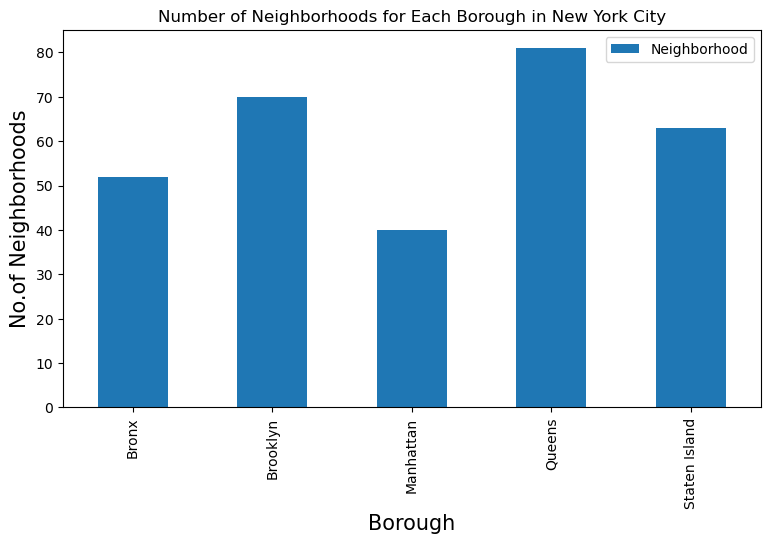

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for Each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhoods', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Based on the data, Queens is the borough with the most number of neighborhoods, with a total of 80.

Manhattan, the most well-known borough and most identified with NYC, has a total of 40 - the least number of neighborhoods.

A neighborhood list is then prepared that contains all NYC restaurants before clustering only Japanese restaurants.

In [12]:
# prepare neighborhood list that contains Japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                            'Neighborhood': Neighborhood,
                                            'ID': id,
                                            'Name' : name
                                        }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

( 138 / 306 ) Japanese Resturants in Richmond Hill, Queens:0
( 139 / 306 ) Japanese Resturants in Flushing, Queens:2
( 140 / 306 ) Japanese Resturants in Long Island City, Queens:1
( 141 / 306 ) Japanese Resturants in Sunnyside, Queens:2
( 142 / 306 ) Japanese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Japanese Resturants in Maspeth, Queens:1
( 144 / 306 ) Japanese Resturants in Ridgewood, Queens:0
( 145 / 306 ) Japanese Resturants in Glendale, Queens:0
( 146 / 306 ) Japanese Resturants in Rego Park, Queens:1
( 147 / 306 ) Japanese Resturants in Woodhaven, Queens:0
( 148 / 306 ) Japanese Resturants in Ozone Park, Queens:0
( 149 / 306 ) Japanese Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Japanese Resturants in College Point, Queens:1
( 151 / 306 ) Japanese Resturants in Whitestone, Queens:2
( 152 / 306 ) Japanese Resturants in Bayside, Queens:0
( 153 / 306 ) Japanese Resturants in Auburndale, Queens:1
( 154 / 306 ) Japanese Resturants in Little Neck, Queens:1
( 155 

( 271 / 306 ) Japanese Resturants in Mount Hope, Bronx:0
( 272 / 306 ) Japanese Resturants in Sutton Place, Manhattan:0
( 273 / 306 ) Japanese Resturants in Hunters Point, Queens:3
( 274 / 306 ) Japanese Resturants in Turtle Bay, Manhattan:3
( 275 / 306 ) Japanese Resturants in Tudor City, Manhattan:4
( 276 / 306 ) Japanese Resturants in Stuyvesant Town, Manhattan:2
( 277 / 306 ) Japanese Resturants in Flatiron, Manhattan:4
( 278 / 306 ) Japanese Resturants in Sunnyside Gardens, Queens:2
( 279 / 306 ) Japanese Resturants in Blissville, Queens:0
( 280 / 306 ) Japanese Resturants in Fulton Ferry, Brooklyn:1
( 281 / 306 ) Japanese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Japanese Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Japanese Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Japanese Resturants in Dumbo, Brooklyn:1
( 285 / 306 ) Japanese Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Japanese Resturants in Willowbrook, Staten Island:0
( 287 / 3

In [13]:
japanese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse


In [14]:
japanese_rest_ny.shape

(191, 4)

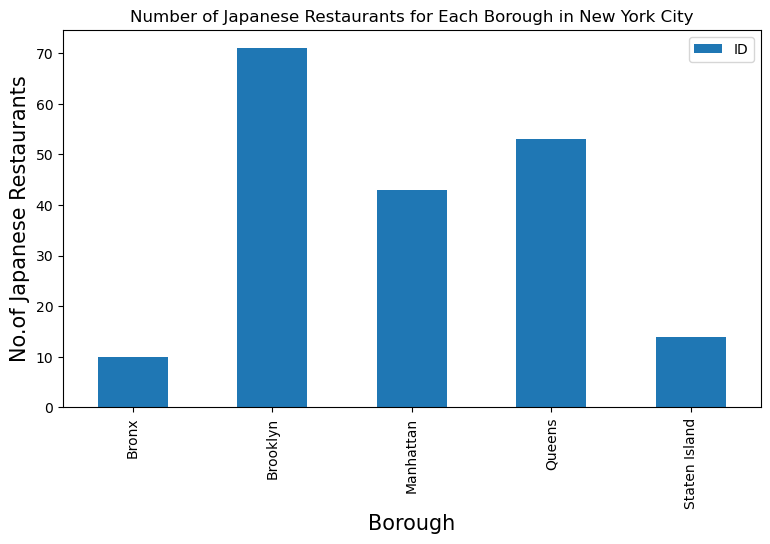

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Restaurants for Each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Restaurants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

As seen in the bar chart above, Brooklyn has the most number of Japanese restaurants, followed by Queens, Manhattan, Staten Island, and the Bronx.

# As seen in the bar chart above, Brooklyn has the most number of Japanese restaurants with 70, followed by Queens, Manhattan, Staten Island, and the Bronx.

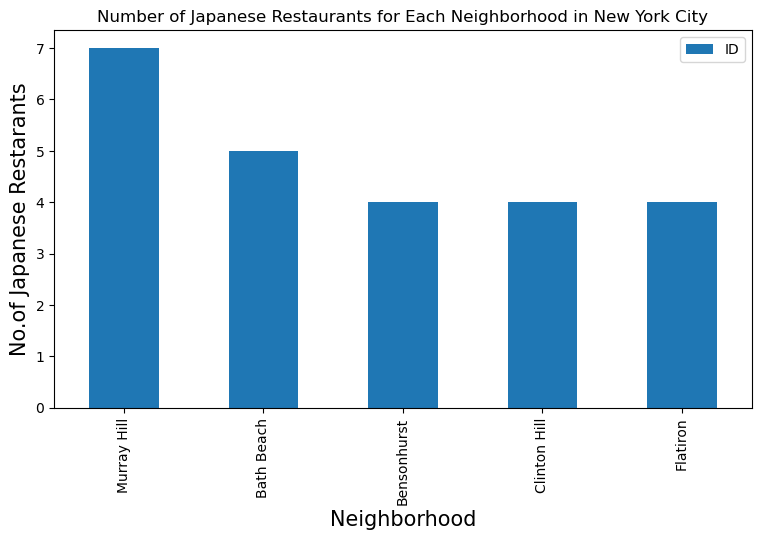

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Restaurants for Each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Restarants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

# In the chart above, Murray Hill has the most Japanese restaurants in the neighborhood with 7, followed by Bath Beach with 5. Bensonhurst, Clinton Hill, and Flatiron each have 4.

# Interestingly enough, upon further analysis as seen below, Murray Hill is the name of a neighborhood ("same name") that is found in 2 different boroughs: Manhattan (total of 5) and Queens (total of 2).

In [17]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
81,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
82,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
83,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
84,Manhattan,Murray Hill,49db8b67f964a520d85e1fe3,Aburiya Kinnosuke
85,Manhattan,Murray Hill,5ad925da2f97ec3e4b17eba2,Nonono
123,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi
124,Queens,Murray Hill,5cf07afa66f3cd002c8b3ae6,Izakaya Mew


# The other neighborhoods summarized below, such as Bath Beach, Bensonhurst, Clinton Hill, an Flatiron are singularly named and located with their boroughs.

In [18]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Bath Beach']

,Borough,Neighborhood,ID,Name
42,Brooklyn,Bath Beach,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant
43,Brooklyn,Bath Beach,4c326b9fa0ced13ac126156e,Ichi Sushi
44,Brooklyn,Bath Beach,4b787863f964a52080d02ee3,Shiki Japanese Hibachi
45,Brooklyn,Bath Beach,513e7ec8e4b07f4fa1b53b3d,Fuki Sushi Japanese Restaurant
46,Brooklyn,Bath Beach,4bad45c9f964a52089403be3,Chikurin


In [19]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Bensonhurst']

,Borough,Neighborhood,ID,Name
13,Brooklyn,Bensonhurst,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant
14,Brooklyn,Bensonhurst,4b787863f964a52080d02ee3,Shiki Japanese Hibachi
15,Brooklyn,Bensonhurst,513e7ec8e4b07f4fa1b53b3d,Fuki Sushi Japanese Restaurant
16,Brooklyn,Bensonhurst,4c326b9fa0ced13ac126156e,Ichi Sushi


In [20]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Clinton Hill']

,Borough,Neighborhood,ID,Name
50,Brooklyn,Clinton Hill,591f7c5f35f9836382455eca,U-Gu
51,Brooklyn,Clinton Hill,5739c66c498e7ef6085cec4f,Karasu
52,Brooklyn,Clinton Hill,5aa09a586eda026624b25ecb,66S Fusion
53,Brooklyn,Clinton Hill,4e3cadcb1f6e844231dbe017,Waza


In [21]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Flatiron']

,Borough,Neighborhood,ID,Name
178,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
179,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
180,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
181,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago


In [23]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
print("hi")
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        print("inside try")
        venue_details=get_venue_details(ID)
        print(venue_details)
        if venue_details is not None:
            id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood,
                                                    'ID': id,
                                                    'Name' : name,
                                                    'Likes' : likes,
                                                    'Rating' : rating,
                                                    'Tips' : tips
                                                }, ignore_index=True)
    count+=1

hi
inside try
https://api.foursquare.com/v2/venues/503cfaffe4b066d39de5005a?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 200, 'requestId': '601f0986d47a0161be7b018d'}, 'response': {'venue': {'id': '503cfaffe4b066d39de5005a', 'name': 'Aoyu Japanese Restaurant', 'contact': {'phone': '7188846633', 'formattedPhone': '(718) 884-6633'}, 'location': {'address': '3532A Johnson Ave', 'lat': 40.88625663623957, 'lng': -73.90971942607067, 'labeledLatLngs': [{'label': 'display', 'lat': 40.88625663623957, 'lng': -73.90971942607067}, {'label': 'entrance', 'lat': 40.886222, 'lng': -73.90965}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3532A Johnson Ave', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aoyu-japanese-restaurant/503cfaffe4b066d39de5005a', 'categories': [{'id': '4bf58dd8d48988d1

{'meta': {'code': 200, 'requestId': '601f0986e81d5a0bdbb7d3b5'}, 'response': {'venue': {'id': '503cfaffe4b066d39de5005a', 'name': 'Aoyu Japanese Restaurant', 'contact': {'phone': '7188846633', 'formattedPhone': '(718) 884-6633'}, 'location': {'address': '3532A Johnson Ave', 'lat': 40.88625663623957, 'lng': -73.90971942607067, 'labeledLatLngs': [{'label': 'display', 'lat': 40.88625663623957, 'lng': -73.90971942607067}, {'label': 'entrance', 'lat': 40.886222, 'lng': -73.90965}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3532A Johnson Ave', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aoyu-japanese-restaurant/503cfaffe4b066d39de5005a', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary':

{'meta': {'code': 200, 'requestId': '601f09873922b21d02d7742e'}, 'response': {'venue': {'id': '4dbdf3d790a02849cbd675be', 'name': 'Ohana Japanese Habachi Seafood & Steakhouse', 'contact': {'phone': '7188850700', 'formattedPhone': '(718) 885-0700', 'twitter': 'ohanacityisland'}, 'location': {'address': '500 City Island Ave', 'crossStreet': 'at Beach St', 'lat': 40.85215113102018, 'lng': -73.78896162771034, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85215113102018, 'lng': -73.78896162771034}, {'label': 'entrance', 'lat': 40.852193, 'lng': -73.789032}], 'postalCode': '10464', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['500 City Island Ave (at Beach St)', 'Bronx, NY 10464', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ohana-japanese-habachi-seafood--steakhouse/4dbdf3d790a02849cbd675be', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': '

{'meta': {'code': 200, 'requestId': '601f098786549955897cf421'}, 'response': {'venue': {'id': '5c79cb8360255e002c86ffaf', 'name': 'IKKO Hibachi Sushi Asian Bistro', 'contact': {}, 'location': {'address': '3938 E Tremont Ave', 'lat': 40.821156, 'lng': -73.818528, 'labeledLatLngs': [{'label': 'display', 'lat': 40.821156, 'lng': -73.818528}], 'postalCode': '10465', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3938 E Tremont Ave', 'New York, NY 10465', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ikko-hibachi-sushi-asian-bistro/5c79cb8360255e002c86ffaf', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {

{'meta': {'code': 200, 'requestId': '601f0988ab38cc30e59a882d'}, 'response': {'venue': {'id': '4b0b311af964a520642e23e3', 'name': 'Palace of Japan', 'contact': {'phone': '7185438833', 'formattedPhone': '(718) 543-8833', 'twitter': 'palaceofjapan'}, 'location': {'address': '3505 Johnson Ave', 'crossStreet': 'btwn 235th and 236th', 'lat': 40.88584088190632, 'lng': -73.91006439099525, 'labeledLatLngs': [{'label': 'display', 'lat': 40.88584088190632, 'lng': -73.91006439099525}, {'label': 'entrance', 'lat': 40.885878, 'lng': -73.910066}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3505 Johnson Ave (btwn 235th and 236th)', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/palace-of-japan/4b0b311af964a520642e23e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4s

{'meta': {'code': 200, 'requestId': '601f0988ddc79358778bd89a'}, 'response': {'venue': {'id': '54e0efc3498e7eda5dff1847', 'name': 'Sarku', 'contact': {}, 'location': {'address': '815 Hutchinson River Pkwy', 'crossStreet': 'Lafayette Avenue', 'lat': 40.82372994464501, 'lng': -73.8381675921118, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82372994464501, 'lng': -73.8381675921118}], 'postalCode': '10465', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['815 Hutchinson River Pkwy (Lafayette Avenue)', 'Bronx, NY 10465', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sarku/54e0efc3498e7eda5dff1847', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'message': 

{'meta': {'code': 200, 'requestId': '601f09894efd9f4b6d24d8aa'}, 'response': {'venue': {'id': '4b33fd94f964a520842325e3', 'name': 'Arirang Hibachi Steakhouse', 'contact': {'phone': '7182389880', 'formattedPhone': '(718) 238-9880'}, 'location': {'address': '8814 4th Ave', 'crossStreet': 'btwn 88th & 89th street', 'lat': 40.62116794545947, 'lng': -74.02929930965014, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62116794545947, 'lng': -74.02929930965014}, {'label': 'entrance', 'lat': 40.621061, 'lng': -74.029254}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8814 4th Ave (btwn 88th & 89th street)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/arirang-hibachi-steakhouse/4b33fd94f964a520842325e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi

{'meta': {'code': 200, 'requestId': '601f0989ddc79358778bdb9b'}, 'response': {'venue': {'id': '51f42bb3498e2681264e00a1', 'name': 'Kasumi Sushi & BBQ Restaurant', 'contact': {'phone': '7189756999', 'formattedPhone': '(718) 975-6999'}, 'location': {'address': '1870 86th St', 'lat': 40.60605, 'lng': -74.001092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60605, 'lng': -74.001092}, {'label': 'entrance', 'lat': 40.606109, 'lng': -74.00103}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1870 86th St', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kasumi-sushi--bbq-restaurant/51f42bb3498e2681264e00a1', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '601f098a494b10566147d601'}, 'response': {'venue': {'id': '4c326b9fa0ced13ac126156e', 'name': 'Ichi Sushi', 'contact': {'phone': '7183732929', 'formattedPhone': '(718) 373-2929'}, 'location': {'address': '2040 86th St', 'lat': 40.60404941998062, 'lng': -73.99741244318324, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60404941998062, 'lng': -73.99741244318324}, {'label': 'entrance', 'lat': 40.603931, 'lng': -73.997424}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2040 86th St', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ichi-sushi/4c326b9fa0ced13ac126156e', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '601f098aeddf1f3e6b3221e0'}, 'response': {'venue': {'id': '5e4c841b1485b40007d77e6e', 'name': 'Rule Of Thirds', 'contact': {'phone': '3473346684', 'formattedPhone': '(347) 334-6684', 'instagram': 'thirdsbk'}, 'location': {'address': '171 Banker St', 'crossStreet': 'Norman St', 'lat': 40.724699, 'lng': -73.955177, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724699, 'lng': -73.955177}], 'postalCode': '11222', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 Banker St (Norman St)', 'New York, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rule-of-thirds/5e4c841b1485b40007d77e6e', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11e941735', 'name

{'meta': {'code': 200, 'requestId': '601f098badb8144690ed655c'}, 'response': {'venue': {'id': '5236313711d25d0f9d3f3b67', 'name': 'Momo Hibachi Steak House & Bar', 'contact': {'phone': '7187698010', 'formattedPhone': '(718) 769-8010'}, 'location': {'address': '1901 Emmons Ave Ste 110', 'lat': 40.58354976555866, 'lng': -73.94910105279351, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58354976555866, 'lng': -73.94910105279351}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1901 Emmons Ave Ste 110', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/momo-hibachi-steak-house--bar/5236313711d25d0f9d3f3b67', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 's

{'meta': {'code': 200, 'requestId': '601f098b21d85f1b7a3bda34'}, 'response': {'venue': {'id': '4bf890acabdaef3b69b7a184', 'name': 'Masake', 'contact': {'phone': '7189988670', 'formattedPhone': '(718) 998-8670'}, 'location': {'address': '1704 Avenue M', 'crossStreet': 'btwn E 17th St & E 18th St', 'lat': 40.61822685283506, 'lng': -73.95796086182948, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61822685283506, 'lng': -73.95796086182948}, {'label': 'entrance', 'lat': 40.618135, 'lng': -73.957875}], 'postalCode': '11230', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1704 Avenue M (btwn E 17th St & E 18th St)', 'Brooklyn, NY 11230', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masake/4bf890acabdaef3b69b7a184', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japa

https://api.foursquare.com/v2/venues/4d1004a56331a0930a505494?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 200, 'requestId': '601f098b96b0581860f959a6'}, 'response': {'venue': {'id': '4d1004a56331a0930a505494', 'name': 'Sakura Tokyo', 'contact': {'phone': '7187568787', 'formattedPhone': '(718) 756-8787'}, 'location': {'address': '604 Nostrand Ave', 'crossStreet': 'Pacific street', 'lat': 40.677897509005255, 'lng': -73.94979755256308, 'labeledLatLngs': [{'label': 'display', 'lat': 40.677897509005255, 'lng': -73.94979755256308}, {'label': 'entrance', 'lat': 40.677919, 'lng': -73.949868}], 'postalCode': '11216', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['604 Nostrand Ave (Pacific street)', 'Brooklyn, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sakura-tokyo/4d1004a56331a0930a505494', 'categories': [{'id'

inside try
https://api.foursquare.com/v2/venues/5091d1ffe4b0f08bb9df6701?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 200, 'requestId': '601f098c348f4025edc3a629'}, 'response': {'venue': {'id': '5091d1ffe4b0f08bb9df6701', 'name': 'Masago Bistro', 'contact': {'phone': '7187788828', 'formattedPhone': '(718) 778-8828'}, 'location': {'address': '766 Nostrand Ave', 'crossStreet': 'Sterling Pl', 'lat': 40.672378, 'lng': -73.950536, 'labeledLatLngs': [{'label': 'display', 'lat': 40.672378, 'lng': -73.950536}, {'label': 'entrance', 'lat': 40.67237, 'lng': -73.950393}], 'postalCode': '11216', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['766 Nostrand Ave (Sterling Pl)', 'Brooklyn, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masago-bistro/5091d1ffe4b0f08bb9df6701', 'categories': [{'id': '4bf58dd8d48988d111941735'

https://api.foursquare.com/v2/venues/4d5c12a01e43236a87eb1583?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 200, 'requestId': '601f098cd650d43b20696056'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', '

{'meta': {'code': 200, 'requestId': '601f098cdd3d4e0198293eab'}, 'response': {'venue': {'id': '5cb5e5f9a35f4600255406c6', 'name': 'Maison Yaki', 'contact': {'phone': '7185522609', 'formattedPhone': '(718) 552-2609', 'twitter': 'maisonyaki', 'instagram': 'maisonyaki', 'facebook': '272996516936741', 'facebookUsername': 'maisonyaki', 'facebookName': 'Maison Yaki'}, 'location': {'address': '626 Vanderbilt Ave', 'crossStreet': 'Prospect Place', 'lat': 40.67747521328162, 'lng': -73.96908078141962, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67747521328162, 'lng': -73.96908078141962}], 'postalCode': '11238', 'cc': 'US', 'neighborhood': 'Prospect Heights', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['626 Vanderbilt Ave (Prospect Place)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maison-yaki/5cb5e5f9a35f4600255406c6', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName

{'meta': {'code': 200, 'requestId': '601f098c5964966eb938e535'}, 'response': {'venue': {'id': '41478600f964a520c41c1fe3', 'name': 'Geido', 'contact': {'phone': '7186388866', 'formattedPhone': '(718) 638-8866'}, 'location': {'address': '331 Flatbush Ave', 'crossStreet': 'Park Place and Prospect Place', 'lat': 40.67784893308722, 'lng': -73.9729250617067, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67784893308722, 'lng': -73.9729250617067}, {'label': 'entrance', 'lat': 40.677872, 'lng': -73.972758}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['331 Flatbush Ave (Park Place and Prospect Place)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/geido/41478600f964a520c41c1fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '601f098c2a22065e8cb1b086'}, 'response': {'venue': {'id': '51f9b7b3498eefe896caeb23', 'name': 'Shalom Japan', 'contact': {'phone': '7183884012', 'formattedPhone': '(718) 388-4012', 'twitter': 'shalomjapan'}, 'location': {'address': '310 S 4th St', 'crossStreet': 'at Rodney St', 'lat': 40.709219, 'lng': -73.955839, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709219, 'lng': -73.955839}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['310 S 4th St (at Rodney St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shalom-japan/51f9b7b3498eefe896caeb23', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f1066b79fd', 'nam

{'meta': {'code': 200, 'requestId': '601f098dd0162b48e2e243f1'}, 'response': {'venue': {'id': '4c7f0887fb74236a7727f9b9', 'name': 'Samurai Mama', 'contact': {'phone': '7185996161', 'formattedPhone': '(718) 599-6161'}, 'location': {'address': '205 Grand St', 'crossStreet': 'btwn Bedford & Driggs Ave', 'lat': 40.71411421938972, 'lng': -73.96019631848635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71411421938972, 'lng': -73.96019631848635}, {'label': 'entrance', 'lat': 40.714135, 'lng': -73.960149}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['205 Grand St (btwn Bedford & Driggs Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/samurai-mama/4c7f0887fb74236a7727f9b9', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '601f098dbb60154a021e3081'}, 'response': {'venue': {'id': '5b3bcb69bfc6d0002ca9bf17', 'name': 'Warude', 'contact': {}, 'location': {'address': '387 Tompkins', 'lat': 40.684409678801586, 'lng': -73.94411847251774, 'labeledLatLngs': [{'label': 'display', 'lat': 40.684409678801586, 'lng': -73.94411847251774}], 'postalCode': '11216', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['387 Tompkins', 'New York, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/warude/5b3bcb69bfc6d0002ca9bf17', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss

{'meta': {'code': 200, 'requestId': '601f098d21d85f1b7a3be17c'}, 'response': {'venue': {'id': '48a41073f964a52091511fe3', 'name': 'Hibino', 'contact': {'phone': '7182608052', 'formattedPhone': '(718) 260-8052', 'twitter': 'hibino_brooklyn', 'facebook': '301149720034179', 'facebookUsername': 'hibinobklyn', 'facebookName': 'Hibino Brooklyn'}, 'location': {'address': '333 Henry St', 'crossStreet': 'at Pacific St', 'lat': 40.69007601730789, 'lng': -73.99649744997076, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69007601730789, 'lng': -73.99649744997076}, {'label': 'entrance', 'lat': 40.690164, 'lng': -73.996383}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Henry St (at Pacific St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hibino/48a41073f964a52091511fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Rest

{'meta': {'code': 200, 'requestId': '601f098dcf264901ad1dd165'}, 'response': {'venue': {'id': '48a41073f964a52091511fe3', 'name': 'Hibino', 'contact': {'phone': '7182608052', 'formattedPhone': '(718) 260-8052', 'twitter': 'hibino_brooklyn', 'facebook': '301149720034179', 'facebookUsername': 'hibinobklyn', 'facebookName': 'Hibino Brooklyn'}, 'location': {'address': '333 Henry St', 'crossStreet': 'at Pacific St', 'lat': 40.69007601730789, 'lng': -73.99649744997076, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69007601730789, 'lng': -73.99649744997076}, {'label': 'entrance', 'lat': 40.690164, 'lng': -73.996383}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Henry St (at Pacific St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hibino/48a41073f964a52091511fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Rest

{'meta': {'code': 200, 'requestId': '601f098e7dd0c2586d8e8756'}, 'response': {'venue': {'id': '5e4f270b03b7910008721f2e', 'name': 'Karazishi Botan', 'contact': {'phone': '3477631155', 'formattedPhone': '(347) 763-1155', 'instagram': 'karazishi_botan', 'facebook': '110365083873021', 'facebookUsername': 'KarazishiBotanBKLYN', 'facebookName': 'Karazishi Botan'}, 'location': {'address': '255 Smith St', 'crossStreet': 'Degraw St', 'lat': 40.683154, 'lng': -73.992888, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683154, 'lng': -73.992888}], 'postalCode': '11231', 'cc': 'US', 'neighborhood': 'Boerum Hill', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['255 Smith St (Degraw St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/karazishi-botan/5e4f270b03b7910008721f2e', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon'

{'meta': {'code': 200, 'requestId': '601f098e71d3842d24689db1'}, 'response': {'venue': {'id': '5276d39a498eb1a5d90096e4', 'name': 'Sushi Katsuei', 'contact': {'phone': '7187885338', 'formattedPhone': '(718) 788-5338', 'instagram': 'sushikatsuei', 'facebook': '566743240069984', 'facebookUsername': 'SushiKatsuei', 'facebookName': 'Sushi Katsuei'}, 'location': {'address': '210 7th Ave', 'crossStreet': 'at 3rd St', 'lat': 40.67061519402922, 'lng': -73.97850388946965, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67061519402922, 'lng': -73.97850388946965}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 7th Ave (at 3rd St)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sushi-katsuei/5276d39a498eb1a5d90096e4', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'htt

{'meta': {'code': 200, 'requestId': '601f098efc223506bc9258f6'}, 'response': {'venue': {'id': '55bbd332498ea08332b67e48', 'name': 'Sarku Japan', 'contact': {'phone': '7182575802', 'formattedPhone': '(718) 257-5802'}, 'location': {'address': '11114 Flatlands Aveneue', 'crossStreet': 'Louisiana Avenue', 'lat': 40.65060752201089, 'lng': -73.89007817093561, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65060752201089, 'lng': -73.89007817093561}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['11114 Flatlands Aveneue (Louisiana Avenue)', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sarku-japan/55bbd332498ea08332b67e48', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id'

{'meta': {'code': 200, 'requestId': '601f098fa82a1d192be3e835'}, 'response': {'venue': {'id': '51f42bb3498e2681264e00a1', 'name': 'Kasumi Sushi & BBQ Restaurant', 'contact': {'phone': '7189756999', 'formattedPhone': '(718) 975-6999'}, 'location': {'address': '1870 86th St', 'lat': 40.60605, 'lng': -74.001092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60605, 'lng': -74.001092}, {'label': 'entrance', 'lat': 40.606109, 'lng': -74.00103}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1870 86th St', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kasumi-sushi--bbq-restaurant/51f42bb3498e2681264e00a1', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '601f098f5964966eb938ef8a'}, 'response': {'venue': {'id': '4b787863f964a52080d02ee3', 'name': 'Shiki Japanese Hibachi', 'contact': {'phone': '7188371586', 'formattedPhone': '(718) 837-1586'}, 'location': {'address': '1863 86th St', 'crossStreet': 'at 19th Ave.', 'lat': 40.606545000000004, 'lng': -74.000928, 'labeledLatLngs': [{'label': 'display', 'lat': 40.606545000000004, 'lng': -74.000928}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1863 86th St (at 19th Ave.)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shiki-japanese-hibachi/4b787863f964a52080d02ee3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

inside try
https://api.foursquare.com/v2/venues/538e057d498e5865fbe8e9aa?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 200, 'requestId': '601f09907b01ca06dfeb5df5'}, 'response': {'venue': {'id': '538e057d498e5865fbe8e9aa', 'name': 'Hibachi Master', 'contact': {'phone': '3476626118', 'formattedPhone': '(347) 662-6118'}, 'location': {'address': '8512 5th Ave', 'crossStreet': 'Btwn 85th and 86th St', 'lat': 40.622007, 'lng': -74.026143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622007, 'lng': -74.026143}, {'label': 'entrance', 'lat': 40.621928, 'lng': -74.026009}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8512 5th Ave (Btwn 85th and 86th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hibachi-master/538e057d498e5865fbe8e9aa', 'categories': [{'id': '4bf58dd8d4

{'meta': {'code': 200, 'requestId': '601f09902819f13b48e961db'}, 'response': {'venue': {'id': '4c140e42a1010f4742d24b18', 'name': 'Sakura', 'contact': {'phone': '7186460666', 'formattedPhone': '(718) 646-0666'}, 'location': {'address': '3118 Avenue U', 'crossStreet': 'at Gerritsen Ave.', 'lat': 40.60185076318859, 'lng': -73.93450273815975, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60185076318859, 'lng': -73.93450273815975}, {'label': 'entrance', 'lat': 40.601947, 'lng': -73.934495}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3118 Avenue U (at Gerritsen Ave.)', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sakura/4c140e42a1010f4742d24b18', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': 

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f09912fb7cf11ea9f93c0'}, 'response': {}}
None
( 54 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/5946d138e2da1964625ca9b2?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f099186549955897d1356'}, 'response': {}}
None
( 55 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/58a202a25490d30f87553a08?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f099155b9505d040c2926'}, 'response': {}}
None
( 56 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/58a202a25490d30f875

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f0994d8e9d44e78e377cf'}, 'response': {}}
None
( 76 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/531a0207498e06b4656eb8c5?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f09940b267d16117951a8'}, 'response': {}}
None
( 77 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4fb93e46e4b0d0dd7eb666c6?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f099483076b1f23d8b513'}, 'response': {}}
None
( 78 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/5aa1d85d5f68b931b6f

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f09978d2f9d46e9850785'}, 'response': {}}
None
( 99 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4c100cd3b93cc9b6482156e0?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f0997adb8144690ed8b4c'}, 'response': {}}
None
( 100 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4bba1c4b1261d13a243cea98?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f0997faf0227239415032'}, 'response': {}}
None
( 101 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/45da8cc4f964a520f

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f099a2a22065e8cb1db61'}, 'response': {}}
None
( 121 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4bf716a85317a5930e72fd7e?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f099a899c746b408e0bb8'}, 'response': {}}
None
( 122 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4cf1b6e98333224b19350c8e?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f099b55b9505d040c457e'}, 'response': {}}
None
( 123 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4bc8eee83740b713

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f099da82a1d192be412c4'}, 'response': {}}
None
( 143 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4bad3dcbf964a520173d3be3?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f099d2aaae823b6af7b95'}, 'response': {}}
None
( 144 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4ba57c41f964a520c60b39e3?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f099d2fb7cf11ea9fb888'}, 'response': {}}
None
( 145 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4e4e4a61bd4101d0

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f09a0d8e9d44e78e39ba4'}, 'response': {}}
None
( 166 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/52b470f511d2522f86497c9b?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f09a017c17d182cb27de3'}, 'response': {}}
None
( 167 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/5718e217498e458de03e94c8?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f09a0ddc79358778c21d0'}, 'response': {}}
None
( 168 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/5bb7e3ced48ec100

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f09a21b5a8003ec895723'}, 'response': {}}
None
( 188 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/584de48c01f433697d786f21?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f09a369227478a21dda84'}, 'response': {}}
None
( 189 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4c6038b654ac0f4736f7b421?&client_id=1EVBZSDTXZBSLMZURSV2F1HHL2PDL1T454KB0CLTZJNVZWZ4&client_secret=KLO1SQIOB1QQKXZCS4NOL2EI1D3YWPFGNIFXMRGSVQ3S0VWU&v=20200605
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '601f09a355b9505d040c5e33'}, 'response': {}}
None
( 190 / 191 ) processed
inside try
https://api.foursquare.com/v2/venues/4a6e0664f964a520

# Our analysis further includes the Venue ID (of the restaurant), Name of the Restaurant, Likes, Ratings, and Tips

In [24]:
japanese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.0,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.0,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.7,18


In [25]:
japanese_rest_stats_ny.shape

(191, 7)

In [26]:
japanese_rest_ny.shape

(191, 4)

# Of the 306 neighborhoods, 191 of them have Japanese restaurants. 

The information is saved to a csv file for analysis.

In [27]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny.csv', index=False)

In [28]:
japanese_rest_stats_ny_csv=pd.read_csv('japanese_rest_stats_ny.csv')

In [29]:
japanese_rest_stats_ny_csv.shape

(191, 7)

In [30]:
japanese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.0,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.0,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.7,18


In [31]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       191 non-null    object 
 1   Neighborhood  191 non-null    object 
 2   ID            191 non-null    object 
 3   Name          191 non-null    object 
 4   Likes         191 non-null    object 
 5   Rating        191 non-null    float64
 6   Tips          191 non-null    object 
dtypes: float64(1), object(6)
memory usage: 10.6+ KB


# Our analysis indicates that select columns have object dtypes rather than float dtypes; hence, the pandas.Series.astype is used to convert the "Likes", "Tips', and "Ratings" object dtypes for consistency in the data analysis.

In [32]:
japanese_rest_stats_ny['Likes']=japanese_rest_stats_ny['Likes'].astype('float64')

In [33]:
japanese_rest_stats_ny['Tips']=japanese_rest_stats_ny['Tips'].astype('float64')

In [35]:
japanese_rest_stats_ny['Rating']=japanese_rest_stats_ny['Rating'].astype('float64')

In [36]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       191 non-null    object 
 1   Neighborhood  191 non-null    object 
 2   ID            191 non-null    object 
 3   Name          191 non-null    object 
 4   Likes         191 non-null    float64
 5   Rating        191 non-null    float64
 6   Tips          191 non-null    float64
dtypes: float64(3), object(4)
memory usage: 10.6+ KB


# Analyze Japanese Restaurants in NYC with maximum "Likes".

In [37]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              4c7f0887fb74236a7727f9b9
Name                        Samurai Mama
Likes                                898
Rating                                 9
Tips                                 247
Name: 30, dtype: object

# Analyze Japanese Restaurants in NYC with maximum "Ratings".

In [38]:
# Resturant with maximum Rating
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              5e4c841b1485b40007d77e6e
Name                      Rule Of Thirds
Likes                                 46
Rating                               9.1
Tips                                   6
Name: 18, dtype: object

# Analyze Japanese Restaurants in NYC with maximum "Tips".

In [39]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              4c7f0887fb74236a7727f9b9
Name                        Samurai Mama
Likes                                898
Rating                                 9
Tips                                 247
Name: 30, dtype: object

# Our analysis has revealed that in the borough of Brooklyn, in the neighboorhood of: 1) Williamsburg - the same restaurant has the maximum "Likes" and "Tips"; 2) Greenpoint has the maximum "Ratings".

In [40]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

# The Japanese restaurants in neighborhoods with the highest average ratings are mostly located in Brooklyn and the Bronx.

In [41]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
22,Cobble Hill,9.10
83,Park Slope,8.85
39,Fort Greene,8.80
61,Kingsbridge,8.75
98,Spuyten Duyvil,8.75
92,Riverdale,8.75
11,Brooklyn Heights,8.65
49,Greenpoint,8.65
110,Williamsburg,8.50
85,Prospect Heights,8.40


# Explore the average rating for Japanese restaurants in the NYC boroughs.

In [42]:
ny_borough_stats= japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

There is a 3-borough, average rating tie of 8 among Manhattan, Queens, and Staten Island. This is followed by 7.78 in Brooklyn and 7.57 in the Bronx.

In [43]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.000000
3,Queens,8.000000
4,Staten Island,8.000000
1,Brooklyn,7.780282
0,Bronx,7.570000


# Visualize the average rating of Japanese restaurants in each NYC borough.

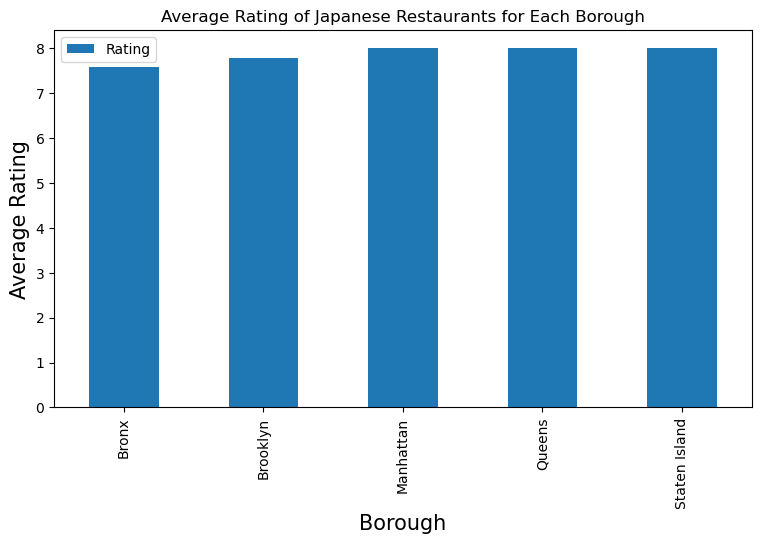

In [44]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average Rating of Japanese Restaurants for Each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the above bar chart, the boroughs of Manhattan, Queens, and Staten Island are tied for the highest avergae rating if 8.0 for Japanese restaurants in the NYC boroughs.

Brooklyn's restaurants average at 7.78 and the Bronx restaurants avergae at 7.57.

This requires further exploration at the Borough - Neighborhood Level.

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

In [46]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [47]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [48]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.65
1,Brooklyn,Cobble Hill,40.687920,-73.998561,9.10
2,Brooklyn,Fort Greene,40.688527,-73.972906,8.80
3,Brooklyn,Greenpoint,40.730201,-73.954241,8.65
4,Bronx,Kingsbridge,40.881687,-73.902818,8.75
5,Brooklyn,Park Slope,40.672321,-73.977050,8.85
6,Bronx,Riverdale,40.890834,-73.912585,8.75
7,Bronx,Spuyten Duyvil,40.881395,-73.917190,8.75
8,Brooklyn,Williamsburg,40.707144,-73.958115,8.50


As seen above, these are the top 9 neighborhoods by borough with the highest average rating of 8.5 or higher for Japanese restaurants. The analysis shows that Brooklyn dominates this category with 6 out of the  9 neighborhoods while the Bronx has the remaining 3 in the list.  

In [60]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [61]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# The map below has been plotted to reflect the top rated neighborhoods for Japanese restaurants; this is in the borough of Brooklyn.

# NOTE: The Notebook must be in TRUSTED mode to ensure proper viewing of the generated map in LINE #64 below.

# ***  Please also note that a screen shot of the generated map has additionally been provided in my GITHUB repository for this assignment in case it cannot be viewed in the Notebook. ***

In [63]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [64]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)
# add incidents to map
ny_map.add_child(incidents)

# *** In case the map cannot be seen in this notebook, please also note that a screen shot of the generated map has also been provided in my GITHUB repository for this assignment. ***

# *** Additionally, the map can be seen in the other 2 required documents for this final assignment. Thank you. ***